In [93]:
import kagglehub
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

# Step 1: Download dataset

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [94]:
#hog features(histogram edged patterns)
def extract_hog_features(image):
    features, _ = hog(image, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, multichannel=False)
    return features

In [95]:
# Step 2: Load images and labels
def load_images(folder_path, label, image_size=(64, 64), limit=100):
    images = []
    labels = []
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, image_size)
                images.append(img.flatten())
                labels.append(label)
                count += 1
            except:
                continue  # Skip unreadable or corrupt images
            if count >= limit:
                break
    return images, labels

In [96]:
# Load cat images
cat_path = os.path.join(path, "PetImages", "Cat")
cat_images, cat_labels = load_images(cat_path, label=0, limit=200)

# Load dog images
dog_path = os.path.join(path, "PetImages", "Dog")
dog_images, dog_labels = load_images(dog_path, label=1, limit=200)

# Combine and convert to arrays
X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

print("Dataset loaded. Shape:", X.shape)

Dataset loaded. Shape: (400, 4096)


In [97]:
# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print("Train/test split done. Shapes:", X_train.shape, X_test.shape)

#Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train/test split done. Shapes: (320, 4096) (80, 4096)


In [98]:
# Step 4: Train SVM
print("Training SVM...")
model = SVC(kernel='rbf', gamma='scale')  # You can also try 'rbf' or 'poly'
model.fit(X_train, y_train)

Training SVM...


SVC()

In [99]:
# Step 5: Predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))

Accuracy: 0.675
              precision    recall  f1-score   support

         Cat       0.75      0.61      0.68        44
         Dog       0.61      0.75      0.68        36

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.68        80
weighted avg       0.69      0.68      0.68        80



In [100]:
import joblib

# Save the trained model
joblib.dump(model, 'svm_cat_dog_model.pkl')
print("Model saved to svm_cat_dog_model.pkl")

Model saved to svm_cat_dog_model.pkl


In [101]:
import pandas as pd

# Store predictions with corresponding labels
pred_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred
})

pred_df.to_csv('svm_predictions.csv', index=False)
print("Predictions saved to svm_predictions.csv")

Predictions saved to svm_predictions.csv


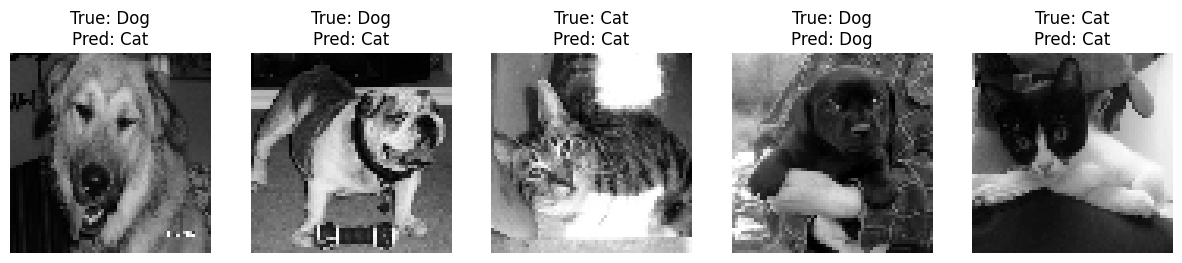

In [102]:
# Step 6: Visualize sample predictions
def show_sample_predictions(X_test, y_test, y_pred, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = X_test[i].reshape(64, 64)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {'Dog' if y_test[i] else 'Cat'}\nPred: {'Dog' if y_pred[i] else 'Cat'}")
        plt.axis('off')
    plt.show()

show_sample_predictions(X_test, y_test, y_pred)